In [127]:
import nltk
nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samchow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [74]:
#Import Data
df= pd.read_hdf('final_data.hdf', 'table')

# Clean missing data by adding NA values to empty strings to later row-wise delete. 
print("The length of the df before deleting is: {}".format(len(df)))

df['strain_list'].replace('', np.nan, inplace=True)
df['review_list'].replace(' ', np.nan, inplace=True)


print(df['strain_list'].isnull().sum())
print(df['review_list'].isnull().sum())

df.dropna(subset=['strain_list'], inplace=True)
df.dropna(subset=['review_list'], inplace=True)

print("The length of the df after deleting is: {}".format(len(df)))



The length of the df before deleting is: 237738
4824
13015
The length of the df after deleting is: 220063


In [140]:
#Prepare stop words to eliminate
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

stop_words.extend(['read', 'more', '_bac', 'grow','look','get','come','obtain',
                  'use','way','get','go','bro','bac','not','not','say','put'])



In [141]:
data= df.review_list.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['first', 'few', 'hours', 'very', 'uplifting', 'experience', 'you', 'slowly', 'feel', 'that', 'you', 'are', 'entering', 'another', 'plane', 'of', 'existence', 'you', 'slowly', 'feel', 'as', 'if', 'you', 'are', 'having', 'very', 'vivid', 'dream', 'of', 'memory', 'the', 'strain', 'brings', 'bac', 'read', 'more']]


In [142]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/samchow/anaconda3/envs/trudope/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['first', 'few', 'hours', 'very', 'uplifting', 'experience', 'you', 'slowly', 'feel', 'that', 'you', 'are', 'entering', 'another', 'plane', 'of', 'existence', 'you', 'slowly', 'feel', 'as', 'if', 'you', 'are', 'having', 'very', 'vivid', 'dream', 'of', 'memory', 'the', 'strain', 'brings_bac', 'read', 'more']


In [143]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [144]:
data_words_nostops = remove_stopwords(data_words)

In [ ]:
data_words_nostops[0]

In [146]:
data_words_bigrams= make_bigrams(data_words_nostops)

In [ ]:
data_words_bigrams

In [148]:
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [ ]:
data_lemmatized

In [151]:
#Creating the Dictionary and Corpus for topic modeling

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1)]]


[[('bring', 1),
  ('dream', 1),
  ('enter', 1),
  ('existence', 1),
  ('experience', 1),
  ('feel', 2),
  ('first', 1),
  ('hour', 1),
  ('memory', 1),
  ('plane', 1),
  ('slowly', 2),
  ('strain', 1),
  ('uplifting', 1),
  ('vivid', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [157]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/samchow/anaconda3/envs/trudope/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
15     0.398782  0.229462       1        1  15.742729
9      0.167482 -0.409688       2        1   9.048282
3      0.065289 -0.049004       3        1   6.569704
5      0.034698 -0.020947       4        1   6.018362
16     0.039518 -0.027098       5        1   5.903885
12    -0.025630  0.021787       6        1   4.885470
0      0.005682 -0.003735       7        1   4.681324
2      0.014265 -0.004692       8        1   4.652740
7     -0.019910  0.004801       9        1   4.493487
6     -0.040554  0.024811      10        1   4.290108
4     -0.045478  0.015129      11        1   4.126707
10    -0.033690  0.008449      12        1   3.900895
19    -0.044968  0.020440      13        1   3.825882
1     -0.060470  0.022023      14        1   3.791928
18    -0.062769  0.028544      15        1   3.745011
13    -0.066387  0.027062      16        1   3.392706
14    -0.073262  0.027851      17        1   3.232902
11    -0.076927  0.022143      18        1   2.939485
17    -0.074166  0.028224      19        1   2.823221
8     -0.101505  0.034439      20        1   1.935169, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
11    Default  89451.000000       strain  89451.000000  30.0000  30.0000
21    Default  60441.000000         good  60441.000000  29.0000  29.0000
133   Default  54402.000000        great  54402.000000  28.0000  28.0000
163   Default  63410.000000         high  63410.000000  27.0000  27.0000
148   Default  33308.000000        taste  33308.000000  26.0000  26.0000
267   Default  28143.000000        smell  28143.000000  25.0000  25.0000
5     Default  29988.000000         feel  29988.000000  24.0000  24.0000
28    Default  22444.000000          bud  22444.000000  23.0000  23.0000
43    Default  37595.000000        smoke  37595.000000  22.0000  22.0000
97    Default  25350.000000       really  25350.000000  21.0000  21.0000
212   Default  19088.000000         love  19088.000000  20.0000  20.0000
281   Default  31463.000000         nice  31463.000000  19.0000  19.0000
184   Default  18125.000000          hit  18125.000000  18.0000  18.0000
70    Default  23303.000000         make  23303.000000  17.0000  17.0000
415   Default  16404.000000         pain  16404.000000  16.0000  16.0000
175   Default  15931.000000       indica  15931.000000  15.0000  15.0000
221   Default  16641.000000          day  16641.000000  14.0000  14.0000
245   Default  16306.000000       strong  16306.000000  13.0000  13.0000
124   Default  24036.000000         time  24036.000000  12.0000  12.0000
89    Default  23378.000000          get  23378.000000  11.0000  11.0000
151   Default  13519.000000       effect  13519.000000  10.0000  10.0000
6     Default  13572.000000        first  13572.000000   9.0000   9.0000
577   Default  12888.000000       sativa  12888.000000   8.0000   8.0000
16    Default  15755.000000         body  15755.000000   7.0000   7.0000
260   Default  13405.000000      amazing  13405.000000   6.0000   6.0000
84    Default  12776.000000          try  12776.000000   5.0000   5.0000
406   Default  10604.000000   definitely  10604.000000   4.0000   4.0000
522   Default   9325.000000        super   9325.000000   3.0000   3.0000
1052  Default  10590.000000        sweet  10590.000000   2.0000   2.0000
136   Default   9757.000000         buzz   9757.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
157   Topic20   2740.095459         calm   2741.063965   3.9446  -2.9902
459   Topic20   2476.928223         haze   2477.896729   3.9446  -3.0912
835   Topic20   1459.346680        house   1460.315186   3.9443  -3.6202
422   Topic20   1399.473877   especially   1400.442383   3.9443  -3.6621
4686  Topic20   1225.951050  train_wreck   1226.919556   3.9442  -3.

In [158]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/Users/samchow/Desktop/InsightsProject/Trudope/mallet-2.0.8/bin/mallet'
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)


In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [160]:
#Train multiple models and provides best coherence score

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

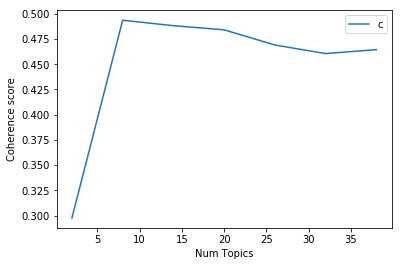

Num Topics = 2  has Coherence Value of 0.2976
Num Topics = 8  has Coherence Value of 0.4936
Num Topics = 14  has Coherence Value of 0.4882
Num Topics = 20  has Coherence Value of 0.4841
Num Topics = 26  has Coherence Value of 0.4691
Num Topics = 32  has Coherence Value of 0.4606
Num Topics = 38  has Coherence Value of 0.4645


In [161]:
#Train and show graph and print outputs

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [ ]:
#Find most repreentative document for each topic

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
#Topic Distribution

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics